# Hidden Markov Model

Today we'll do a test case using hidden markov models to monitor hidden states. Our first setup will be pretty simple--two hidden states, on and off, each resulting in detections at sparse measurements (meaning three possible detection values: detect, non-detect, no measurement). We allow for the possibility of false negatives (non-detects when on) and false positives (detects when off). We generate a time series based on the model and try to recover it using hmmlearn's fit method.  



In [2]:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt


In [173]:
class run_hmm:

    def __init__(self):
        
        np.random.seed(42)
        self.t_len = 100
    def gen_data(self):
        self.model = hmm.CategoricalHMM(n_components=2)
        
        self.model.startprob_ = np.array([0.6, 0.4])
        
        # transmission matrix
        # two hidden states: 0 is off, 1 is on
        self.model.transmat_ = np.array([[0.95, 0.05], # state 0 to states 0, 1
        
                                    [0.01, 0.99]]) # states 1 to states 0, 1
        # emission matrix
        # we'll code 3 states: detection, non-detection, no measurement
        
        no_measurement = 0.5
        detection_fraction_on = 0.5
        detection_fraction_off = 0.1
        self.model.emissionprob_ = np.array([[(1-no_measurement)*(1-detection_fraction_off), (1-no_measurement)*(detection_fraction_off), no_measurement],
                                       [(1-no_measurement)*(1-detection_fraction_on), (1-no_measurement)*(detection_fraction_on), no_measurement]])
        
        self.observations, self.hidden_states = self.model.sample(self.t_len)
        self.obs = self.observations.flatten()
        self.obs = self.obs.astype('float')
        self.obs[self.obs==2] = np.nan

    def fit_data(self, emissions_guess=None, transmission_guess=None):
        self.fitted_model = hmm.CategoricalHMM(n_components=2)
        if emissions_guess is not None:
            self.fitted_model.emissionprob_ = emissions_guess
        if transmission_guess is not None:
            self.fitted_model.transmat_ = transmission_guess
        self.inferred_hidden_states = self.fitted_model.fit(self.observations)
        self.inferred_hidden_states = self.fitted_model.predict(self.observations)
        

    def plot_data(self):
        plt.scatter(np.arange(self.t_len), self.obs, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],alpha=0.5, label='observations')
        plt.plot(np.arange(self.t_len), self.hidden_states, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], label='hidden state')
        plt.plot(np.arange(self.t_len), self.inferred_hidden_states, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], alpha=0.3,linestyle='--',label='inferred hidden state')
        plt.legend()
        plt.title('HMM Hidden State (On/Off) and Observations (Detect / Non-Detect) with Missing Data')
        return

Let's generate our data, look at the emissions and transmission probabilities, run our first model, and see what the results are.

In [178]:
rhmm = run_hmm()
rhmm.gen_data()


In [179]:
rhmm.model.emissionprob_

array([[0.45, 0.05, 0.5 ],
       [0.25, 0.25, 0.5 ]])

In [180]:
rhmm.model.transmat_

array([[0.95, 0.05],
       [0.01, 0.99]])

In [181]:
rhmm.fit_data()

In [182]:
rhmm.fitted_model.emissionprob_

array([[0.2850755 , 0.14631093, 0.56861356],
       [0.40443132, 0.12338699, 0.4721817 ]])

In [183]:
rhmm.fitted_model.transmat_

array([[1.07235075e-04, 9.99892765e-01],
       [3.98354410e-01, 6.01645590e-01]])

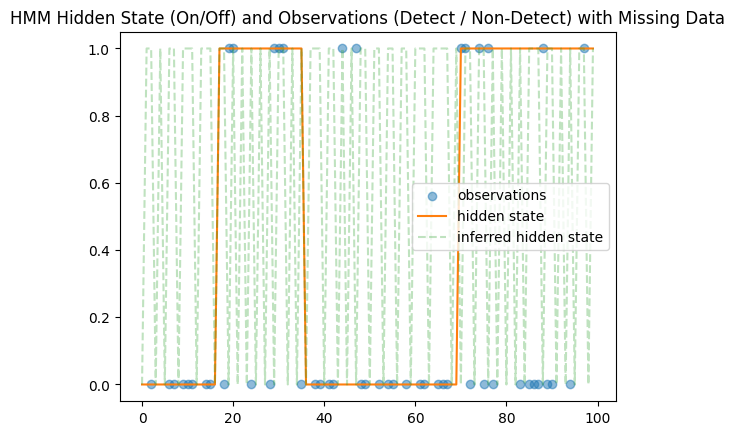

In [184]:
rhmm.plot_data()

### Results 

The results aren't great--definitely overfit to a local maxima in the solution space. Let's try passing in reasonable start values:

In [185]:
trans_g = np.array([[0.9, 0.1],[0.1, 0.9]])
em_g = np.array([[0.4,0.1, 0.5],[0.2,0.3, 0.5]])

rhmm.fit_data(emissions_guess=em_g, transmission_guess=trans_g)

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


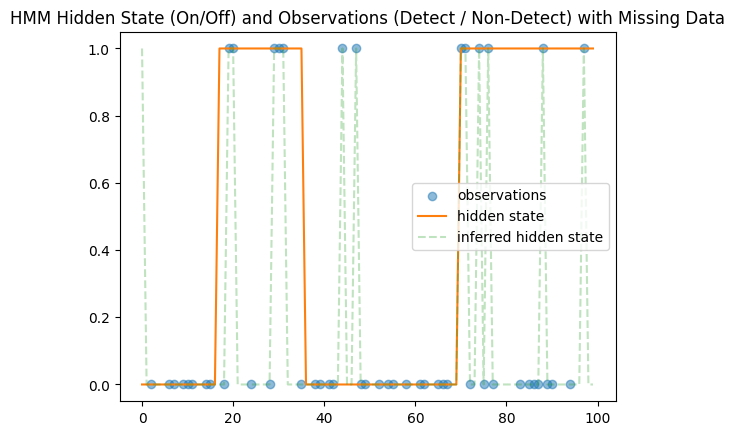

In [186]:
rhmm.plot_data()

In [187]:
rhmm.fitted_model.emissionprob_

array([[0.4587871 , 0.06635505, 0.47485784],
       [0.13149712, 0.30096518, 0.5675377 ]])

In [188]:
rhmm.fitted_model.transmat_

array([[0.74635989, 0.25364011],
       [0.70431467, 0.29568533]])

### Results

Clearly we did a lot better, but our fitted values still misattributed quite a bit and our fitted transmission matrix is actually further from the truth than our initialized value is! Now, if we know something about the problem, like what we expect our transition matrices are going to look like, we can actually fix some of them rather than fitting them--or at least fit to more reasonable values. Let's try again and see what happens. We can see part of the issue is our transition matrix is too eager to flip to 0. Sometimes what looks like a small number to our perspective (like a couple percentages) might be a large number in terms of where the model equilibrates. Let's try making the transitions a little sparser, initializing it so that we are less likely to flip hidden states:

In [189]:
trans_g = np.array([[0.95, 0.05],[0.05, 0.95]])
em_g = np.array([[0.4,0.1, 0.5],[0.2,0.3, 0.5]])

rhmm.fit_data(emissions_guess=em_g, transmission_guess=trans_g)

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


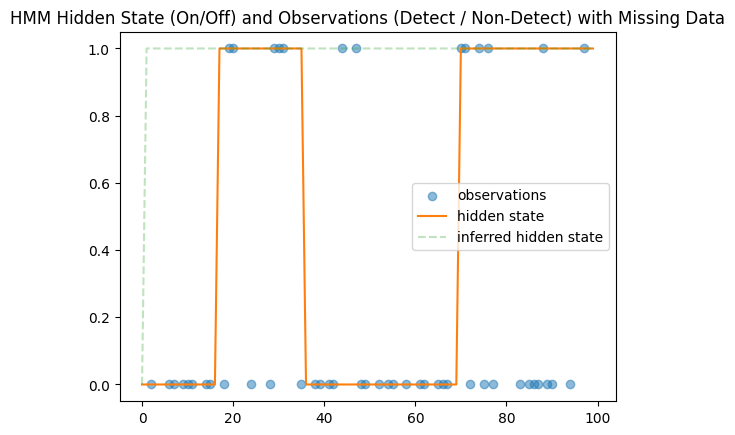

In [190]:
rhmm.plot_data()

In [191]:
rhmm.fitted_model.emissionprob_

array([[0.01675145, 0.01943252, 0.96381603],
       [0.4528876 , 0.15594398, 0.39116842]])

In [192]:
rhmm.fitted_model.transmat_

array([[0.24893126, 0.75106874],
       [0.1663171 , 0.8336829 ]])

### Results

Well, the transition matrix is looking better now, but we've gone too far in the direction of turning on and not turning back off. It's understandable though--we do have two false positives right in the middle of our two streaks of true hidden on state. 



### Further Steps

Try using variational inference rather than EM algo:
https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.vhmm.VariationalCategoricalHMM

Bayesianize param generation such that we have multiple locations but drawing params from similar distributions (and with different sampling per location), so we can model in such a way that we apply learnings from well-sampled locations to poorly sampled locations